#### This notebook is for testing our Engineered Features and choosing base model

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC

In [2]:
# Load the data
data_path = '../data/processed/data.csv'
df = pd.read_csv(data_path)

In [3]:
#==========Helper functions to create new features=================
def add_age_group(df):
    bins = [18, 30, 45, 60, 75, 100]
    labels = ['18-30', '31-45', '46-60', '61-75', '76+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False, include_lowest=True)
    df['age_group'] = df['age_group'].cat.add_categories('Other').fillna('Other')

# Function to Group Primary Diagnosis
def add_diagnosis_group(df):
    diagnosis_mapping = {
        'Hypertension': 'Cardiac',
        'Heart Attack': 'Cardiac',
        'Asthma': 'Respiratory',
        'COPD': 'Respiratory',
        'Diabetes': 'Diabetes-related'
    }
    df['diagnosis_group'] = df['primary_diagnosis'].map(diagnosis_mapping).fillna('Other')

# Function to create Hospital Stay Features
def add_hospital_stay_features(df):
    stay_bins = [0, 3, 7, 14, np.inf]
    stay_labels = ['0-3 days', '4-7 days', '8-14 days', '>14 days']
    df['stay_bucket'] = pd.cut(df['days_in_hospital'], bins=stay_bins, labels=stay_labels)
    df['stay_bucket'] = df['stay_bucket'].cat.add_categories('Other').fillna('Other')

    df['long_stay'] = np.where(df['days_in_hospital'] > 7, 1, 0)
    df['long_stay'] = df['long_stay'].fillna(-1)

# Function to create Procedure Features
def add_procedure_features(df):
    procedure_bins = [0, 1, 3, 5, np.inf]
    procedure_labels = ['None', '1-2', '3-5', '5+']
    df['procedure_category'] = pd.cut(df['num_procedures'], bins=procedure_bins, labels=procedure_labels)
    df['procedure_category'] = df['procedure_category'].cat.add_categories('Other').fillna('Other')

    df['procedures_diagnosis_interaction'] = df['num_procedures'] * df['diagnosis_group'].factorize()[0]

# Function to create Comorbidity Features
def add_comorbidity_features(df):
    comorbidity_threshold = 3
    df['high_risk_comorbidity'] = np.where(df['comorbidity_score'] >= comorbidity_threshold, 1, 0)
    df['high_risk_comorbidity'] = df['high_risk_comorbidity'].fillna(-1)


# Function to create Interaction Terms
def add_interaction_features(df):
    df['age_comorbidity_interaction'] = df['age'] * df['comorbidity_score']
    df['procedures_age_interaction'] = df['num_procedures'] * df['age']
    df['procedures_comorbidity_interaction'] = df['num_procedures'] * df['comorbidity_score']

# Master function to apply all feature engineering
def apply_feature_engineering(df):
    add_age_group(df)
    add_diagnosis_group(df)
    add_hospital_stay_features(df)
    add_procedure_features(df)
    add_comorbidity_features(df)
    add_interaction_features(df)
    return df

In [4]:
# Apply the feature engineering to df
df_new = apply_feature_engineering(df)

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       826
           1       0.20      0.36      0.25       174

    accuracy                           0.64      1000
   macro avg       0.52      0.53      0.51      1000
weighted avg       0.73      0.64      0.67      1000

Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       826
           1       0.17      0.07      0.10       174

    accuracy                           0.78      1000
   macro avg       0.50      0.50      0.49      1000
weighted avg       0.71      0.78      0.74      1000

Training eXtreme Gradient Boosting...

eXtreme Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       826
         

<Figure size 1200x600 with 0 Axes>

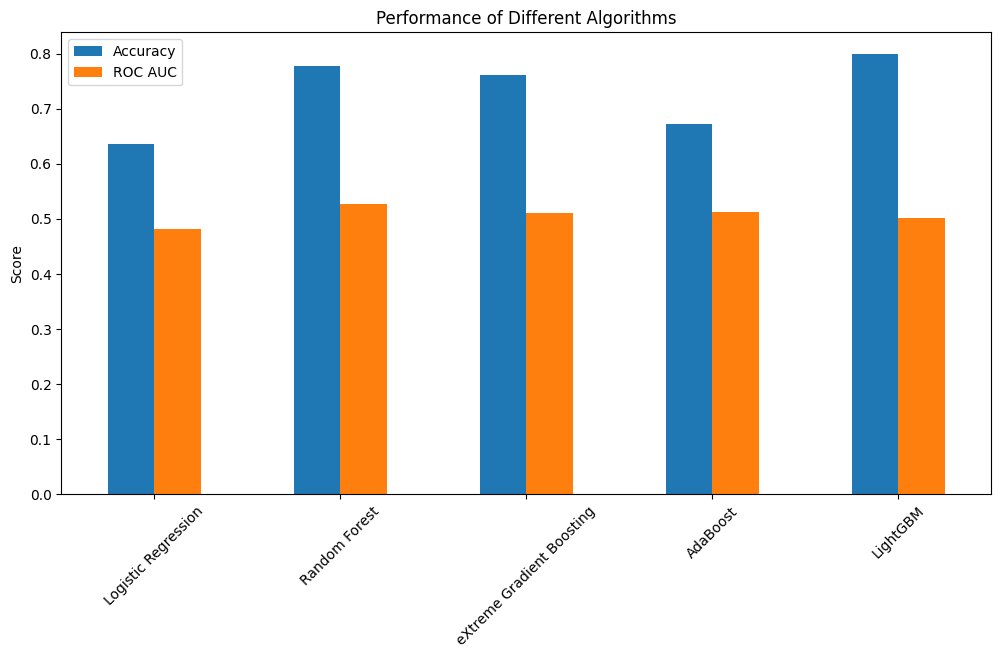

In [5]:
# Define the target and features
X = df_new.drop(columns=['readmitted'])  # Features
y = df_new['readmitted']  # Target

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Encode categorical columns using LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTENC to balance the data (for categorical + numerical data)
smote = SMOTENC(categorical_features=[X.columns.get_loc(col) for col in categorical_cols], random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'eXtreme Gradient Boosting': XGBClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Evaluate each model and store results
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_smote, y_train_smote)

    # Predict on the test set
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int) if hasattr(model, "predict_proba") else y_pred_prob

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if hasattr(model, "predict_proba") else 'N/A'

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    results[model_name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc
    }

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results).T

# Plot the results
plt.figure(figsize=(12, 6))
results_df[['Accuracy', 'ROC AUC']].plot(kind='bar', figsize=(12,6))
plt.title('Performance of Different Algorithms')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()